# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize -- This has been deprecated
#from scipy import misc
#import imageio
#import imageio.v2 as imageio
import datetime
import os
import cv2 #install opencv-python
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30) #Getting deprecated error
tf.random.set_seed(30)

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, ConvLSTM2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
#batch_size_temp = 20 #experiment with the batch size

In [5]:
num_classes=5 # number of classes
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
channels=3

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
#num_epochs = 5 # choose the number of epochs  
#print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100


In [8]:
#Setting some of the Processing Atributes
#image_count1 = 30 # number of images to be used for each video
#image_height_temp= 120 #160
#image_width_temp= 120 #160
#input_shape=(image_count1,image_width_temp,image_height_temp,channels)


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [17]:
def generator(source_path, folder_list, batch_size, frames_to_sample=20,total_sample=30,image_width=160,image_height=160,augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = [x for x in range(0,total_sample)] #create a list of image numbers you want to use for a particular video
    img_idx = np.round(np.linspace(0,total_sample-1,frames_to_sample)).astype(int) #Randomize the picking of frames too.
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,total_sample,image_width,image_height,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,num_classes)) # batch_labels is the one hot representation of the output
 
            if (augment): 
                batch_data_aug = np.zeros((batch_size,total_sample,image_width,image_height,channels))

            #batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            #batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = misc.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = cv2.resize(image,(image_width,image_height))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                    if (augment):
                        shifted = cv2.warpAffine(image, 
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 

                        cropped=shifted[x0:x1,y0:y1,:]
                        
                        image_resized = cv2.resize(cropped,(image_width,image_height))
                        
                        #M = cv2.getRotationMatrix2D((image_width//2,image_height//2),
                        #                        np.random.randint(-10,10), 1.0)
                        #temp = cv2.warpAffine(image_resized, M, (image_width,image_height))

                        temp = image_resized/255 #Normalize data

                        batch_data_aug[folder,idx,:,:,0] = (temp[:,:,0])
                        batch_data_aug[folder,idx,:,:,1] = (temp[:,:,1])
                        batch_data_aug[folder,idx,:,:,2] = (temp[:,:,2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size1 = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size1,total_sample,image_width,image_height,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size1,num_classes)) # batch_labels is the one hot representation of the output
 
            if (augment): 
                batch_data_aug = np.zeros((batch_size1,total_sample,image_width,image_height,channels))

            for folder in range(batch_size1): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size1)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = misc.imread(source_path+'/'+ t[folder + (batch*batch_size1)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = io.imread(source_path+'/'+ t[folder + (batch*batch_size1)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size1)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)                    
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size1)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = cv2.resize(image,(image_width,image_height))
                    temp = temp/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                    if (augment):
                        shifted = cv2.warpAffine(image, 
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 

                        cropped=shifted[x0:x1,y0:y1,:]
                        
                        image_resized = cv2.resize(cropped,(image_width,image_height))
                        
                        #M = cv2.getRotationMatrix2D((image_width//2,image_height//2),
                        #                        np.random.randint(-10,10), 1.0)
                        #temp = cv2.warpAffine(image_resized, M, (image_width,image_height))

                        temp = image_resized/255 #Normalize data

                        batch_data_aug[folder,idx,:,:,0] = (temp[:,:,0])
                        batch_data_aug[folder,idx,:,:,1] = (temp[:,:,1])
                        batch_data_aug[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size1)].strip().split(';')[2])] = 1

            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            
            yield batch_data, batch_labels


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [7]:
def trigger_model(model, train_path, train_doc, batch_size,augment=False, frames_to_sample=16, total_frames=30, epochs=5, image_width=160, image_height=160):
    
    train_generator = generator(train_path, train_doc, batch_size, frames_to_sample, total_frames, image_width, image_height,augment)
    val_generator = generator(val_path, val_doc, batch_size, frames_to_sample, total_frames, image_width, image_height)
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq =1)

    LR = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,factor=0.2)# write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    
    history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,
                  callbacks=callbacks_list, validation_data=val_generator,
                 validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)
    
    plot_graph(history,epochs)
    
    return history

Graph Plotting Function to centralize it using a function 

In [8]:
def plot_graph(history,epochs):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1 

In [10]:
#Model 1

def define_model1(image_width=160,image_height=160,frame_count=30):
    
    model_shape=(frame_count,image_width,image_height,channels)
    
    model = Sequential()
    #model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)))
    model.add(Conv3D(16, (3, 3, 3), activation='relu', padding = 'Same', input_shape=model_shape))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding = 'Same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',padding = 'Same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu',padding = 'Same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    #Trying a different combination of hidden layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes,activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print("Total Params:", model.count_params())
    print("")
    return model

### Model 2 

In [11]:
#Model 2 - changing the Layer Size and adding Normalization
def define_model2(image_width=160,image_height=160,frame_count=30):
    
    model_shape=(frame_count,image_width,image_height,channels)

    model = Sequential()
    #model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)))
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding = 'Same', input_shape=model_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',padding = 'Same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu',padding = 'Same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding = 'Same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))


    model.add(Flatten())

    #Trying a different combination of hidden layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes,activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    print("Total Params:", model.count_params())
    print("")

    return model

### Model 3

In [12]:
#Model 3 - Keeping the Layer Size the same from Model 3 and removing the BatchNormalization
def define_model3(image_width=160,image_height=160,frame_count=30):
    
    model_shape=(frame_count,image_width,image_height,channels)

    model = Sequential()
    #model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)))
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding = 'Same', input_shape=model_shape))
    #model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',padding = 'Same'))
    #model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu',padding = 'Same'))
    #mode.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding = 'Same'))
    #model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    #Trying a different combination of hidden layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes,activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    print("Total Params:", model.count_params())
    print("")
    return model

### Model 4

In [13]:
#Model 4 - Modifying Model 3 to use TimeDistribution and batch Normalization 
def define_model4(image_width=160,image_height=160,frame_count=30):
    
    model_shape=(frame_count,image_width,image_height,channels)
    
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=model_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(GRU(128))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    print("Total Params:", model.count_params())
    print("")

    return model

### Model 5

In [14]:
#Model 5 - Modifying Model 4 with increase in Dense Neurons to 128 and no Batch Normalization
def define_model5(image_width=160,image_height=160,frame_count=30):

    model_shape=(frame_count,image_width,image_height,channels)

    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=model_shape))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(GRU(128))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    print("Total Params:", model.count_params())
    print("")
    return model

### Model 6

In [12]:
#Model 6 - Modifying Model 5 with dropouts and Dense Layer having 128 neurons
def define_model6(image_width=160,image_height=160,frame_count=30):

    model_shape=(frame_count,image_width,image_height,channels)
    
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=model_shape))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))

    model.add(GRU(128))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))

    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    print("Total Params:", model.count_params())
    print("")
    return model

### Model 7

In [16]:
#Model 7 - Modifying Model 6 with lower Neurons at each layers and no dropouts
def define_model7(image_width=160,image_height=160,frame_count=30):

    model_shape=(frame_count,image_width,image_height,channels)
    
    model = Sequential()

    model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'), input_shape=model_shape))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(Dropout(0.25))

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(Dropout(0.25))

    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(Dropout(0.25))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))

    model.add(GRU(128))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))

    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    print("Total Params:", model.count_params())
    print("")
    return model

### Model 8

In [18]:
#Model 8 - Modifying Model 6 and using LTSM
def define_model8(image_width=160,image_height=160,frame_count=30):

    model_shape=(frame_count,image_width,image_height,channels)

    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=model_shape))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(128))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    print("Total Params:", model.count_params())
    print("")
    return model

### Model 9

In [9]:
#Model 9 - Modifying Model 8 by lower the Layer weigths
def define_model9(image_width=160,image_height=160,frame_count=30):

    model_shape=(frame_count,image_width,image_height,channels)

    model = Sequential()

    model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'), input_shape=model_shape))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    #model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(128))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    print("Total Params:", model.count_params())
    print("")
    return model

In [20]:

from keras.applications import ResNet152V2

def define_model10(image_width=160,image_height=160,frame_count=30):
    
    model_shape=(frame_count,image_width,image_height,channels)
    # EfficientNetB7 with rnn gru units
    model = Sequential()
    model.add(TimeDistributed(ResNet152V2(weights='imagenet', include_top=False),input_shape=model_shape, name='ResNet152V2', trainable=False))
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(GRU(128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
        
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002) #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    print("Total Params:", model.count_params())
    print("")
    return model

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Total Params: 1938949

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10


34/34 [==============================] - ETA: 0s - loss: 1.6619 - categorical_accuracy: 0.2278Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2811_30_20.082894\model-00001-1.66189-0.22775-1.60711-0.28000.h5
34/34 [==============================] - 139s 4s/step - loss: 1.6619 - categorical_accuracy: 0.2278 - val_loss: 1.6071 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 2/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - ETA: 0s - loss: 1.6084 - categorical_accuracy: 0.2127
Epoch 2: saving model to model_init_2024-02-2811_30_20.082894\model-00002-1.60841-0.21267-1.60485-0.21000.h5
34/34 [==============================] - 141s 4s/step - loss: 1.6084 - categorical_accuracy: 0.2127 - val_loss: 1.6049 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.6050 - categorical_accuracy: 0.1931
Epoch 3: saving model to model_init_2024-02-2811_30_20.082894\model-00003-1.60502-0.19306-1.60637-0.16000.h5
34/34 [==============================] - 146s 4s/step - loss: 1.6050 - categorical_accuracy: 0.1931 - val_loss: 1.6064 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 4/10
34/34 [==============================] - ETA: 0s - loss: 1.5898 - categorical_accuracy: 0.2338
Epoch 4: saving model to model_init_2024-02-2811_30_20.082894\model-00004-1.58982-0.23379-1.59385-0.20000.h5
34/34 [=================

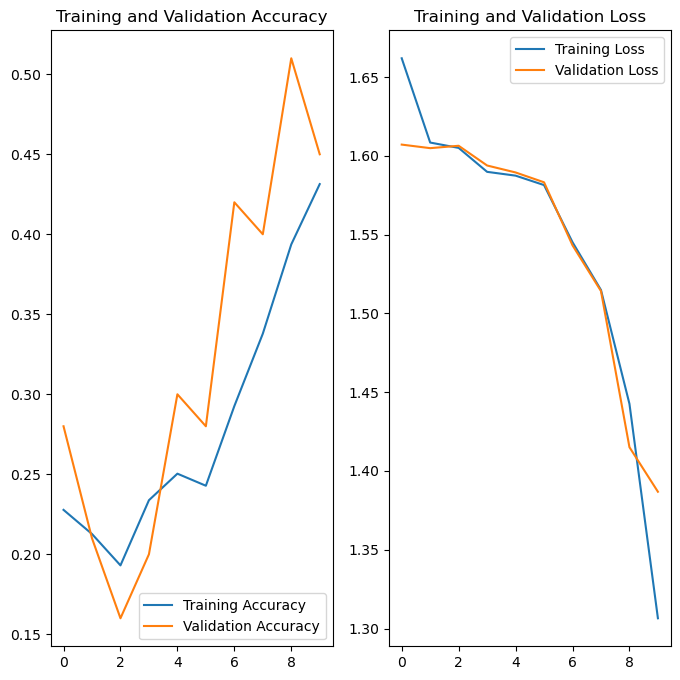

In [18]:
model1 = define_model1()
history1 = trigger_model(model1, train_path,train_doc, batch_size=20,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10,augment=False)
#plot_graph(history1,epochs=20)

##### Model 1 is underfitting in the limited epoch iteration


Total Params: 4451717

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 2.6629 - categorical_accuracy: 0.2549Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2811_30_20.082894\model-00001-2.66287-0.25490-5.12230-0.23000.h5
34/34 [==============================] - 347s 10s/step - loss: 2.6629 - categorical_accuracy: 0.2549 - val_loss: 5.1223 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.5191 - categorical_accuracy: 0.3077 
Epoch 2: saving model to model_init_2024-02-2811_30_20.082894\model-00002-1.51907-0.30769-5.07587-0.20000.h5
34/34 [==============================] - 357s 10s/step - loss: 1.5191 - categorical_accuracy: 0.3077 - val_loss: 5.0759 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.4820 - categorical_accura

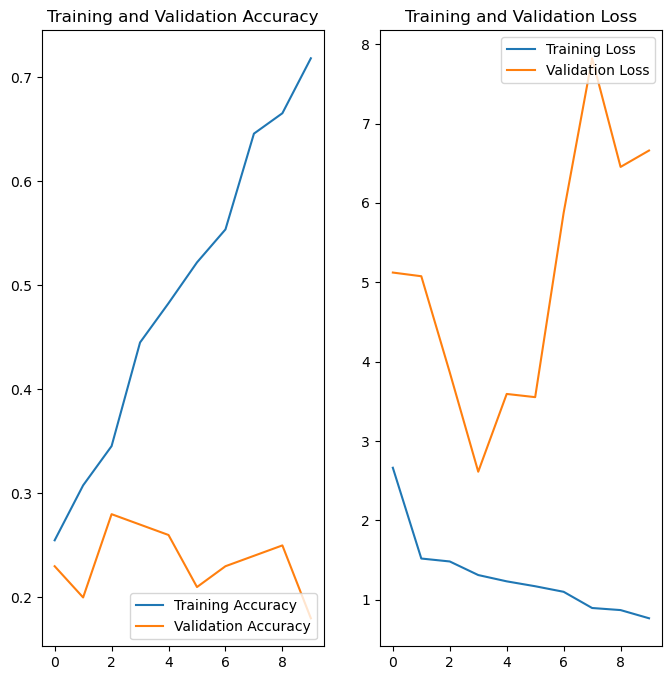

In [19]:
model2 = define_model2()
history2 = trigger_model(model2, train_path,train_doc, batch_size=20,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10,augment=False)

##### Model 2 clearly is showing signs of Overfitting and the Validation accuracy is also pretty Low

Total Params: 4449797

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.6209 - categorical_accuracy: 0.2021Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2811_30_20.082894\model-00001-1.62090-0.20211-1.60203-0.23000.h5
34/34 [==============================] - 298s 9s/step - loss: 1.6209 - categorical_accuracy: 0.2021 - val_loss: 1.6020 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.5983 - categorical_accuracy: 0.2127
Epoch 2: saving model to model_init_2024-02-2811_30_20.082894\model-00002-1.59834-0.21267-1.60247-0.39000.h5
34/34 [==============================] - 244s 7s/step - loss: 1.5983 - categorical_accuracy: 0.2127 - val_loss: 1.6025 - val_categorical_accuracy: 0.3900 - lr: 2.0000e-04
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.5744 - categorical_accuracy: 

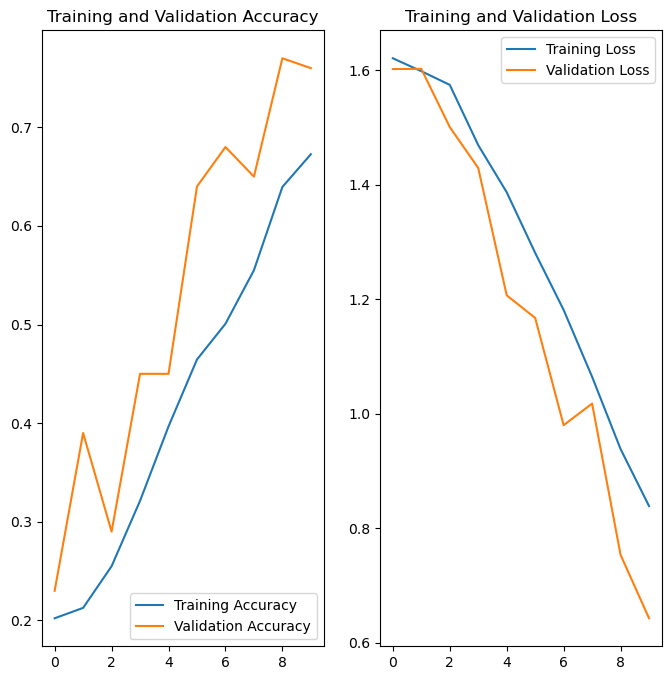

In [20]:
model3 = define_model3()
history3 = trigger_model(model3, train_path,train_doc, batch_size=20,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10,augment=False)

##### Model 3 is performing at consistent level and higher accuracy level with the increase in no.of neurons. Training Accuracy is slightly on the lower side.

Total Params: 10279237

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.4716 - categorical_accuracy: 0.3590 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2811_30_20.082894\model-00001-1.47161-0.35897-2.34690-0.23000.h5
34/34 [==============================] - 372s 11s/step - loss: 1.4716 - categorical_accuracy: 0.3590 - val_loss: 2.3469 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.0943 - categorical_accuracy: 0.5747 
Epoch 2: saving model to model_init_2024-02-2811_30_20.082894\model-00002-1.09431-0.57466-2.12341-0.15000.h5
34/34 [==============================] - 406s 12s/step - loss: 1.0943 - categorical_accuracy: 0.5747 - val_loss: 2.1234 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.9413 - categorical_accur

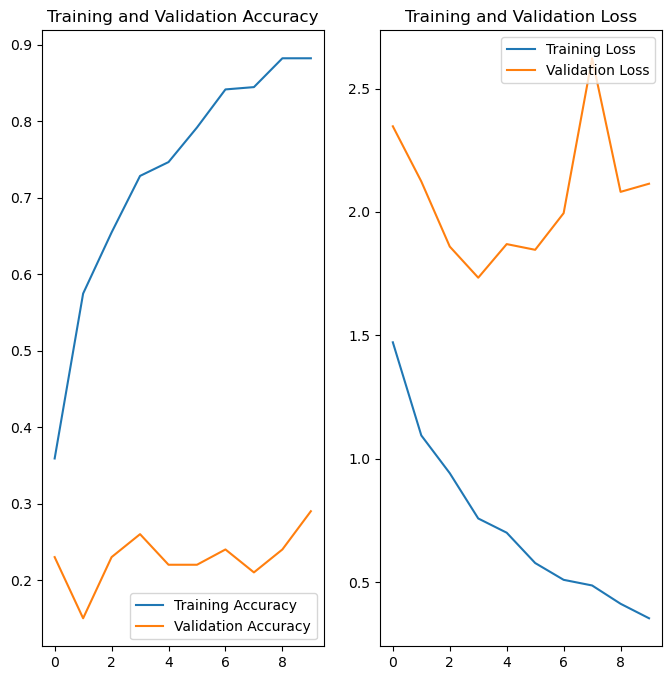

In [21]:
model4 = define_model4()
history4 = trigger_model(model4,train_path,train_doc, batch_size=20,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10,augment=False)

##### Model 4 clearly is showing signs of Overfitting with low Validation Accuracy with BatchNormalization doesn't seem to be helping here.

Total Params: 10285893

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.6140 - categorical_accuracy: 0.1976 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2811_30_20.082894\model-00001-1.61401-0.19759-1.56694-0.23000.h5
34/34 [==============================] - 395s 12s/step - loss: 1.6140 - categorical_accuracy: 0.1976 - val_loss: 1.5669 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.4774 - categorical_accuracy: 0.3650
Epoch 2: saving model to model_init_2024-02-2811_30_20.082894\model-00002-1.47742-0.36501-1.38278-0.43000.h5
34/34 [==============================] - 319s 9s/step - loss: 1.4774 - categorical_accuracy: 0.3650 - val_loss: 1.3828 - val_categorical_accuracy: 0.4300 - lr: 2.0000e-04
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.2111 - categorical_accurac

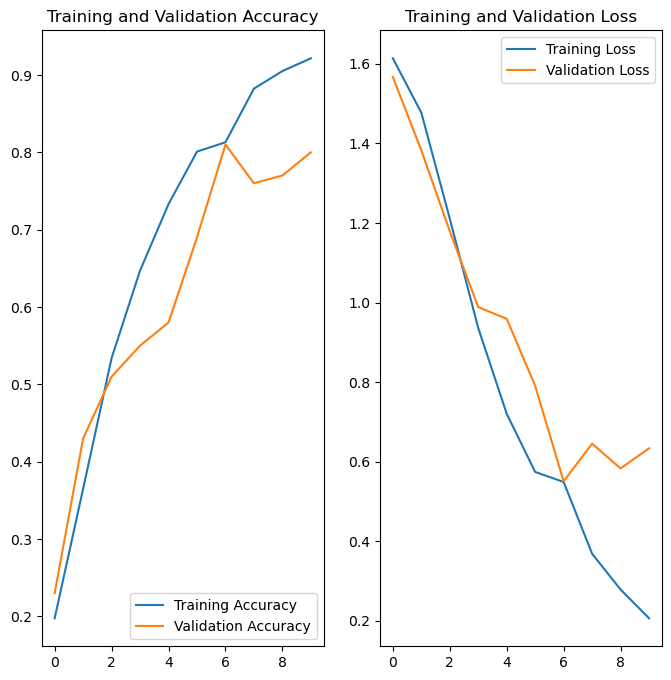

In [22]:
model5 = define_model5()
history5 = trigger_model(model5,train_path,train_doc, batch_size=20,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10,augment=False)

##### Model 5 is displaying good accuracy for Validation and Training Accuracy. Still see some over-fitting issue.



Total Params: 10285893

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10


34/34 [==============================] - ETA: 0s - loss: 1.6705 - categorical_accuracy: 0.1855 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2816_01_31.356509\model-00001-1.67047-0.18552-1.60665-0.24000.h5


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 411s 12s/step - loss: 1.6705 - categorical_accuracy: 0.1855 - val_loss: 1.6066 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.5948 - categorical_accuracy: 0.2112
Epoch 2: saving model to model_init_2024-02-2816_01_31.356509\model-00002-1.59480-0.21116-1.60295-0.28000.h5
34/34 [==============================] - 341s 10s/step - loss: 1.5948 - categorical_accuracy: 0.2112 - val_loss: 1.6030 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.5632 - categorical_accuracy: 0.2730 
Epoch 3: saving model to model_init_2024-02-2816_01_31.356509\model-00003-1.56325-0.27300-1.57786-0.37000.h5
34/34 [==============================] - 364s 11s/step - loss: 1.5632 - categorical_accuracy: 0.2730 - val_loss: 1.5779 - val_categorical_accuracy: 0.3700 - lr: 2.0000e-04
Epoch 4/10
34/34 [==============================] - E

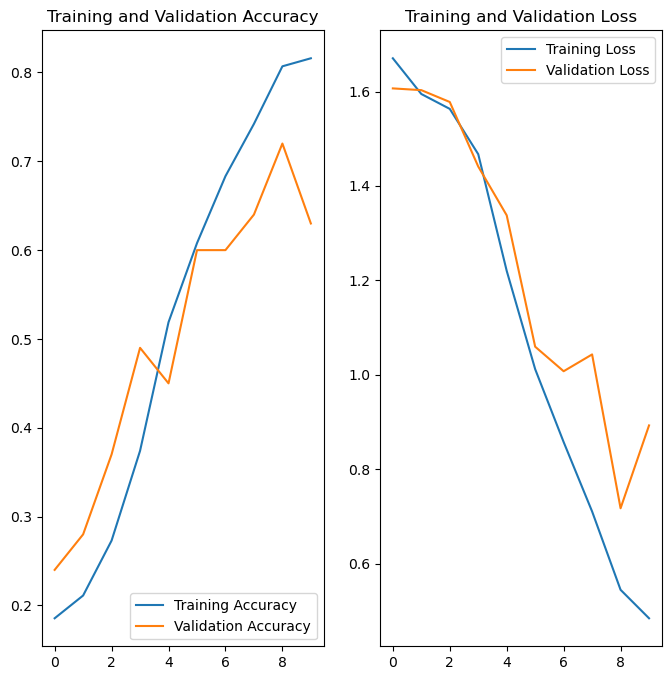

In [15]:
model6 = define_model6()
history6 = trigger_model(model6,train_path,train_doc, batch_size=20,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10,augment=False)

##### Model 6 is showcasing overfitting with dropouts

Total Params: 5025301

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.6092 - categorical_accuracy: 0.2278Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2816_01_31.356509\model-00001-1.60920-0.22775-1.57693-0.28000.h5
34/34 [==============================] - 94s 3s/step - loss: 1.6092 - categorical_accuracy: 0.2278 - val_loss: 1.5769 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.5349 - categorical_accuracy: 0.3167
Epoch 2: saving model to model_init_2024-02-2816_01_31.356509\model-00002-1.53491-0.31674-1.53988-0.28000.h5
34/34 [==============================] - 84s 3s/step - loss: 1.5349 - categorical_accuracy: 0.3167 - val_loss: 1.5399 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.3970 - categorical_accuracy: 0.

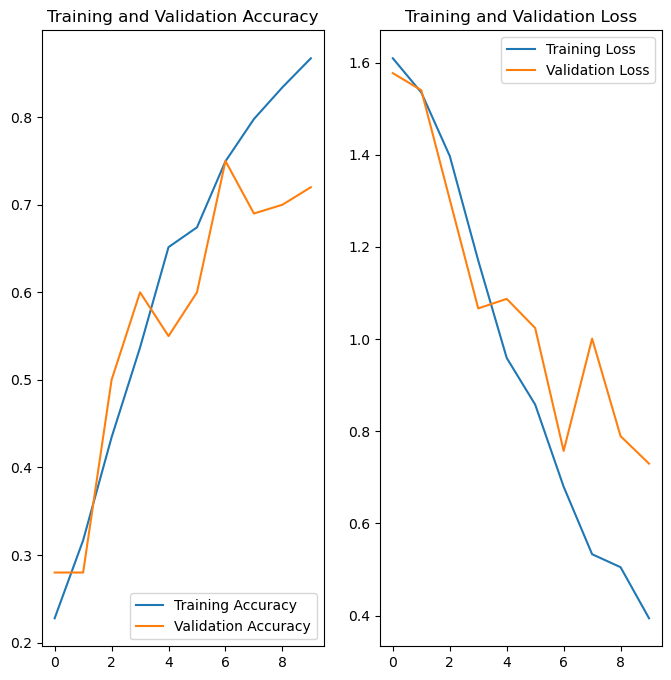

In [17]:
model7 = define_model7()
history7 = trigger_model(model7,train_path,train_doc, batch_size=20,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10,augment=False)

Total Params: 13578821

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.6156 - categorical_accuracy: 0.2278 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2816_01_31.356509\model-00001-1.61557-0.22775-1.56232-0.43000.h5
34/34 [==============================] - 384s 11s/step - loss: 1.6156 - categorical_accuracy: 0.2278 - val_loss: 1.5623 - val_categorical_accuracy: 0.4300 - lr: 2.0000e-04
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.4829 - categorical_accuracy: 0.3424 
Epoch 2: saving model to model_init_2024-02-2816_01_31.356509\model-00002-1.48288-0.34238-1.32829-0.52000.h5
34/34 [==============================] - 364s 11s/step - loss: 1.4829 - categorical_accuracy: 0.3424 - val_loss: 1.3283 - val_categorical_accuracy: 0.5200 - lr: 2.0000e-04
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.2172 - categorical_accur

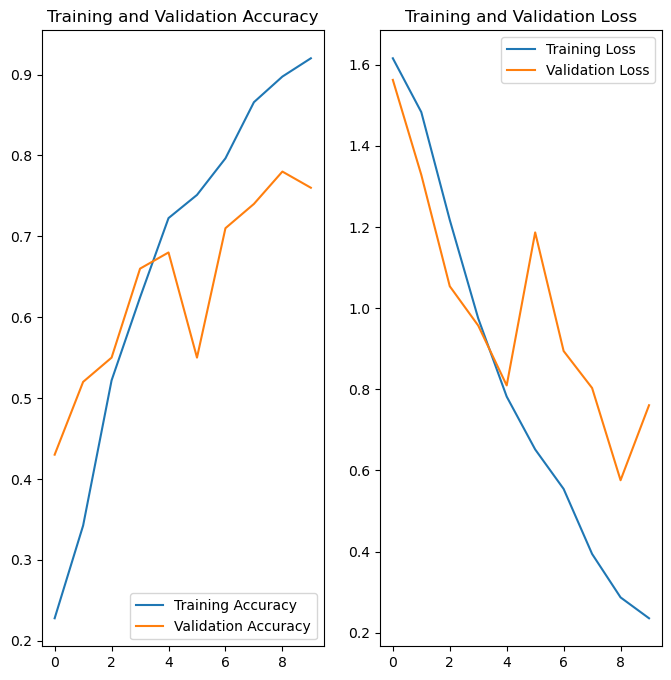

In [21]:
model8 = define_model8()
history8 = trigger_model(model8,train_path,train_doc, batch_size=20,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10,augment=False)

##### Model 8 is overfitting here given that Validation Accuracy us lower compared to the Training Accuracy

Total Params: 3384533

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.6013 - categorical_accuracy: 0.1870Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2024-02-2816_01_31.356509\model-00001-1.60130-0.18703-1.56932-0.40000.h5
34/34 [==============================] - 111s 3s/step - loss: 1.6013 - categorical_accuracy: 0.1870 - val_loss: 1.5693 - val_categorical_accuracy: 0.4000 - lr: 2.0000e-04
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.5003 - categorical_accuracy: 0.3107
Epoch 2: saving model to model_init_2024-02-2816_01_31.356509\model-00002-1.50029-0.31071-1.26269-0.50000.h5
34/34 [==============================] - 96s 3s/step - loss: 1.5003 - categorical_accuracy: 0.3107 - val_loss: 1.2627 - val_categorical_accuracy: 0.5000 - lr: 2.0000e-04
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.2664 - categorical_accuracy: 0

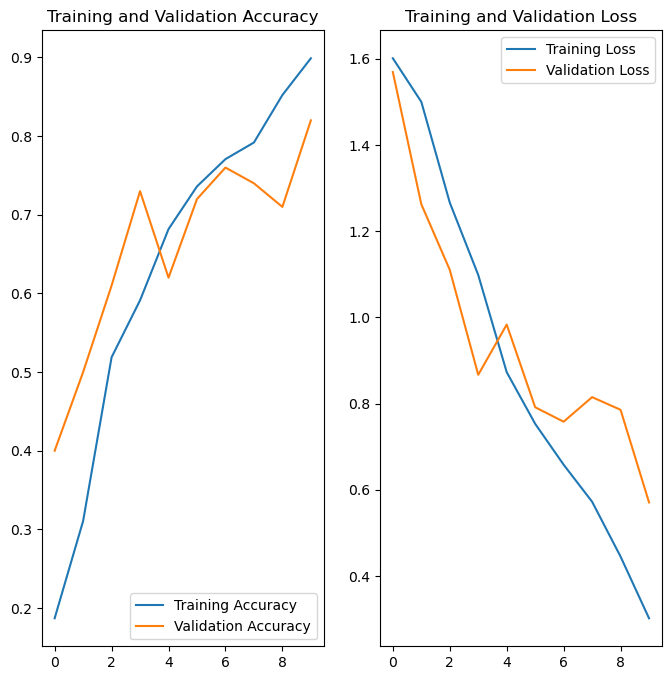

In [26]:
model9 = define_model9()
history9 = trigger_model(model9,train_path,train_doc, batch_size=20,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10,augment=False)

##### Model 9 is giving better accuracy with lesser params than earlier model Model 8

In [22]:
model10 = define_model10()
history10 = trigger_model(model10,train_path,train_doc,batch_size=30,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10,augment=False)

Total Params: 59613765

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/10
 1/23 [>.............................] - ETA: 1:09:25 - loss: 2.0018 - categorical_accuracy: 0.2333

KeyboardInterrupt: 

##### Just taking too long to train the model

### Conclusion:

##### Model 9 is the preferred one since it giving a better Validation Accuracy (82%) result with relative less params and also less training time

#### Performing Additional Operations on the chosen Model

1. Increasing Frames to 30 and Augemented data for Model 9  to see if that impacts the overall Accuracy Rate

Total Params: 3384533

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.5955 - categorical_accuracy: 0.2270Source path =  ./Project_data/val ; batch size = 30
Batch:  4 Index: 30

Epoch 1: saving model to model_init_2024-02-2819_10_17.511857\model-00001-1.59554-0.22700-1.56256-0.33000.h5
23/23 [==============================] - 193s 8s/step - loss: 1.5955 - categorical_accuracy: 0.2270 - val_loss: 1.5626 - val_categorical_accuracy: 0.3300 - lr: 2.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.4719 - categorical_accuracy: 0.3680Batch:  4 Index: 30

Epoch 2: saving model to model_init_2024-02-2819_10_17.511857\model-00002-1.47189-0.36802-1.43916-0.32000.h5
23/23 [==============================] - 176s 8s/step - loss: 1.4719 - categorical_accuracy: 0.3680 - val_loss: 1.4392 - val_categorical_accuracy: 0.3200 - lr: 2.0000e-04
Epoch 3/10
23/23 [==============================] - ETA: 0s

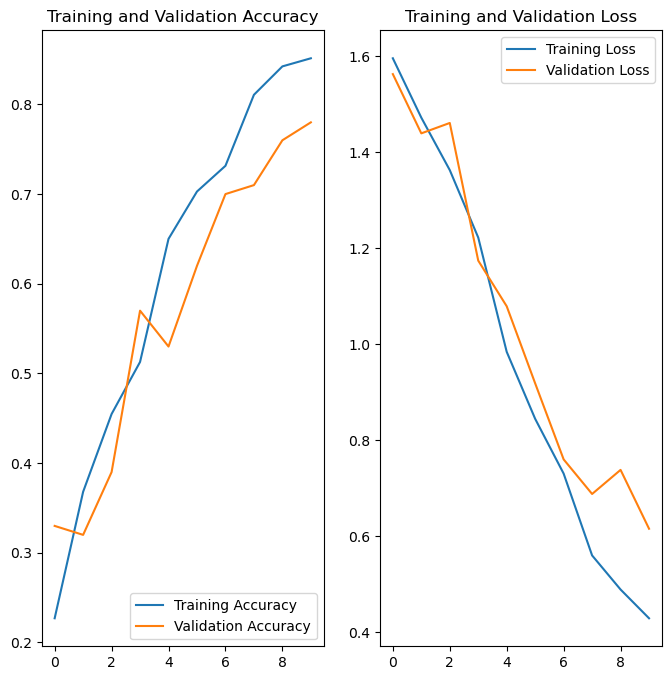

In [12]:
model9a = define_model9()
history9a = trigger_model(model9a,train_path,train_doc,batch_size=30,frames_to_sample=30,total_frames=30,image_width=160,image_height=160,epochs=10,augment=True)

Seems the Data Augmentation is doing nothing to the overall Accuracy as such which means that we need either doing Data Augmentation additionally or do maybe some sort of transferred learning

In all likelihood it will get overfit where it plateau's out at 76-80% range